# Python Tutorial

In [ ]:
# Loop

a = 0

if a == 0:
    b = 1
else:
    b = 2
    
# Dictionary 
    
dict = {'Name': 'Zara', 'Age': 7, 'Class': 'First'}

# How to write in python ?

# Constant -> NAME_SURNAME
# Type -> NameSurname
# Global variable, local variable, fonction -> name_surname

# IMPORT

In [1]:
# Path Desktop

%matplotlib inline

from __future__ import print_function
from sklearn.externals import joblib
from pylab import *
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import mixture
from os.path import basename

import matplotlib.style as ms
ms.use('seaborn-muted')

import math
import time
import glob,os
import pickle
import random
import seaborn
import librosa.display
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, pandas as pd, librosa, urllib, IPython.display, os.path

plt.rcParams['figure.figsize'] = (14, 5)

# ANNOTATIONS EXCEL

You can directly load the labels file here, if it's already saved

In [2]:
labels = pd.DataFrame.from_csv('labels.csv')

labels.head()

,label,dur,start,end,file
0,2,573.0,2.0,575.0,00m12d-1(hungry)_044.wav
1,1,115.0,599.0,714.0,00m12d-1(hungry)_044.wav
2,2,584.0,824.0,1408.0,00m12d-1(hungry)_044.wav
3,1,133.0,1433.0,1566.0,00m12d-1(hungry)_044.wav
4,2,713.0,1709.0,2422.0,00m12d-1(hungry)_044.wav


In [ ]:
label_files = ['044/044.xls','050/050.xls','051/051.xls']
pages = ['hungry','pee','sleepy']
labels = pd.DataFrame()

for label_file in label_files:
    for page in pages: 
        data = pd.read_excel(label_file,page)
        data = data[['Expiration/Inspiration', 'syllable duration', 'syllable start', "comments"]]
        data.rename(inplace=True, columns={'Expiration/Inspiration':'label', 'syllable duration':'dur', 'syllable start':'start', 'comments':'file'})
        labels = pd.concat([labels,data],ignore_index=True)  

labels

In [ ]:
# Localisation Colums 0-3 : test.iloc[0:3]

In [ ]:
# Rename labels : 'SI' -> 0, 'IN' -> 1 et 'EX' -> 2. 

def rename_label1(label_str):
    if label_str == 'IN':
        return 1
    if label_str == 'EX':
        return 2
    return label_str
    
labels['label']=labels['label'].apply(rename_label1)
labels['end']=labels['start']+labels['dur']

# Switch colums

labels = labels[['label', 'dur','start','end','file']]
labels.to_csv('labels.csv')

labels

We can select the first file if we want.

In [ ]:
test_name1 = '01m00d-1(pee&hungry)_050.wav'
test_name2 = '01m13d-1(hungry)_051.wav'
labels[labels.file == test_name2]

# CREATION DATA BASE 

You can directly load the mfcc file here, if it's already saved. 

We have mfcc normalized file because SVM only works with normalized features. We will compare performance for GMM to know if it's better to use normalization or not. 

In [3]:
all_file_mfcc_norm = np.load('all_file_mfcc_norm.npy').item()
all_file_mfcc = np.load('all_file_mfcc.npy').item()

# all_file_mfcc

You can directly load the labels per frames file here, if it's already saved

In [4]:
all_file_frame_labels = np.load('all_file_frame_labels.npy').item()

# all_file_frame_labels

Mfcc extraction

In [ ]:
# Windowing parameters for MFCCs

SAMPLING_RATE = 44100
L_WINDOWS = 0.020
L_HOPS = 0.010
L_WINDOW_N = int(round((L_WINDOWS)/(1./SAMPLING_RATE)))
L_HOP_N = int(round((L_HOPS)/(1./SAMPLING_RATE)))
L_WINDOW_N2 = 2**(L_WINDOW_N-1).bit_length() # POWER OF 2 FOR FFT
L_HOP_N2 = 2**(L_WINDOW_N-1).bit_length()
N_MFCC = 13

In [ ]:
baby_states = ['hungry','pee',"sleepy"]
babies = ['044','050','051']

mfcc_scaler = sklearn.preprocessing.StandardScaler()

# Dictionary of mfcc

all_file_mfcc = {}
all_file_mfcc_norm = {}

for baby in babies:
    for baby_state in baby_states: 
        file_path = baby +'/'+baby_state+'/audio/'  
        for audio_file_path in glob.glob(file_path+'*.wav'):
            audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
            # normalize
            audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))
            # mfcc extraction
            file_mfcc = librosa.feature.mfcc(audio_data, sr=SAMPLING_RATE, \
                                            n_mfcc=N_MFCC, n_fft = L_WINDOW_N, \
                                            hop_length = L_HOP_N).T
            all_file_mfcc[os.path.basename(audio_file_path)]= file_mfcc
            all_file_mfcc_norm[os.path.basename(audio_file_path)]= mfcc_scaler.fit_transform(file_mfcc)

# We transpose the result to accommodate scikit-learn which assumes that each row is one observation, and each column is one feature dimension

np.save('all_file_mfcc.npy', all_file_mfcc)
np.save('all_file_mfcc_norm.npy', all_file_mfcc_norm) 

# all_file_mfcc

In [ ]:
# extract label for each frame in each file

baby_states = ['hungry','pee',"sleepy"]
babies = ['044','050','051']

# Dictionary of labels

all_file_frame_labels = {}

for baby in babies:
    for baby_state in baby_states:
        file_path = baby +'/'+baby_state+'/audio/'
        for audio_file_path in glob.glob(file_path+'*.wav'):
            audio_file = os.path.basename(audio_file_path)
            file_labels = labels[labels['file']==audio_file]
            # frame labels are 0 unless they're in a IN or EX segment (=1 or 2)
            file_frame_labels = []
            frame_positions = [10+10*x for x in range(len(all_file_mfcc[os.path.basename(audio_file_path)]))]
            for frame_position in frame_positions:
                segment = file_labels[(file_labels['start']<frame_position) &(file_labels['end']>frame_position)]
                if not segment.empty:
                    file_frame_labels.append(segment.label.values[0])
                else:
                    file_frame_labels.append(0)
            all_file_frame_labels[os.path.basename(audio_file_path)]= file_frame_labels
                    
np.save('all_file_frame_labels.npy', all_file_frame_labels) 

#  Exemple of a file 

In [5]:
SAMPLING_RATE = 44100

audio_file_path = '044/hungry/audio/00m12d-1(hungry)_044.wav'

audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))

IPython.display.Audio(audio_data, rate=SAMPLING_RATE)

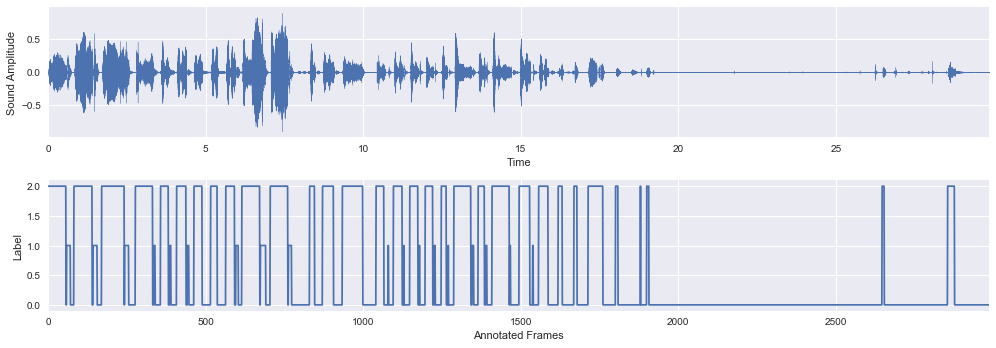

In [6]:
# Plot WaveSound

plt.figure()

plt.subplot(2, 1, 1)
librosa.display.waveplot(audio_data, SAMPLING_RATE)
plt.ylabel('Sound Amplitude')

# Plot excel annotations

plt.subplot(2, 1, 2)
plt.plot(all_file_frame_labels[os.path.basename(audio_file_path)])
plt.ylabel('Label')
plt.xlabel('Annotated Frames')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])
plt.tight_layout()

# SVM creation and hyperparameters

Choose hyperparameters C and Gamma with tenfold Cross-Validation

In [ ]:
C_range = np.logspace(-3, 3, 7)
gamma_range = np.logspace(-3, 3, 7)
param_grid = {'gamma' : gamma_range, 'C' : C_range}
cv = sklearn.model_selection.KFold(n_splits=10, shuffle=False, random_state=None)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(mfcc_dset_norm, labels_dset)
print("The best parameters are " + str(grid.best_params_) + " with a score of " + str(grid.best_score_))

Finer tuning on basis 2 for Gamma

In [ ]:
C_range = [1.0]
gamma_range = [0.015625,0.03125,0.0625,0.125,0.5]
param_grid = {'gamma' : gamma_range, 'C' : C_range}
cv = sklearn.model_selection.KFold(n_splits=10, shuffle=False, random_state=None)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(mfcc_dset_norm, labels_dset)
print("The best parameters are " + str(grid.best_params_) + " with a score of " + str(grid.best_score_))

C = grid.best_params_['C']
gamma = grid.best_params_['gamma']

Fixing C and gamma. C is always 1 and gamma is often 0.0625 or 0.125. We are taking C = 1 and gamma = 0.1.

In [7]:
C = 1
gamma = 0.1

Create svm classifer model object 

In [8]:
model_svm = sklearn.svm.SVC(C = C, gamma = gamma, probability=True)

# GMM creation

Creating and training three GMM for three classes. We choose to use diagonale covariance matrix for GMM because it gives better results than full covariance matrix. It can be explain because full covariance type overfit for small datasets. Or, we know than for some cases we have few datas for case 'IN'.  

In [9]:
def train_gmm3(features_train,labels_train,n_components):
    M0 = mixture.GaussianMixture(n_components = n_components, max_iter = 50, n_init = 20, init_params = 'kmeans', covariance_type='diag')
    M1 = mixture.GaussianMixture(n_components = n_components, max_iter = 50, n_init = 20, init_params = 'kmeans', covariance_type='diag')
    M2 = mixture.GaussianMixture(n_components = n_components, max_iter = 50, n_init = 20, init_params = 'kmeans', covariance_type='diag')
    #
    label_0 = features_train[np.where(labels_train == 0)]
    label_1 = features_train[np.where(labels_train == 1)]
    label_2 = features_train[np.where(labels_train == 2)]
    #
    M0.fit(label_0)
    M1.fit(label_1)
    M2.fit(label_2)
    #
    model = [M0,M1,M2]
    return model

Predict labels and log probability of features for a model

In [10]:
def predict_gmm3(features_test,model):
    M0 = model[0]
    M1 = model[1]
    M2 = model[2]
    # log probability per labels
    lprob_0 = M0.score_samples(features_test)
    lprob_1 = M1.score_samples(features_test)
    lprob_2 = M2.score_samples(features_test)
    lprob = [lprob_0,lprob_1,lprob_2]
    prob = np.exp(lprob)
    # add exits and entries states
    a = np.zeros((1,prob.shape[1]))
    a[a < 1e-100] = 1e-100
    b = prob
    b[b < 1e-100] = 1e-100
    lprob = np.log(concatenate((a,b,a)))
    # predict !
    state_seq = np.zeros(len(lprob_0))
    state_seq [np.where((lprob_0 > lprob_1)&(lprob_0 > lprob_2))] = 0
    state_seq [np.where((lprob_1 > lprob_0)&(lprob_1 > lprob_2))] = 1
    state_seq [np.where((lprob_2 > lprob_0)&(lprob_2 > lprob_1))] = 2
    return lprob, state_seq

In [11]:
def gmm3_score(features_test,labels_test,model):
    state_seq = predict_gmm3(features_test,model)[1]
    new_score = float(len(np.squeeze(np.where(state_seq == labels_test))))/float(len(labels_test))
    return new_score

# HMM Creation

Transforming the outputs of SVM into a probability distribution over classes with Platt scaling extended for the multiclasse case by Wu et al. (A,B) are estimated by maximization of maximum likelihood, probabilities given by 5fold cross validation.     

See "Probability Estimates for Multi-class Classification by Pairwise Coupling" (2004)

In [12]:
def log_lhood_svm(features,model):
    predicted_proba_labels = model.predict_proba(features)
    predicted_proba_labels = predicted_proba_labels.transpose()
    # Add entry and exit states for viterbi
    a = np.zeros((1,predicted_proba_labels.shape[1]))
    a[a < 1e-100] = 1e-100
    b = predicted_proba_labels
    b[b < 1e-100] = 1e-100
    # take the log-probability
    log_lhood = np.log(concatenate((a,b,a)))
    return log_lhood

Training the Transition probability Matrix for Viterbi decoding

In [13]:
def log_trans_matrix(states):
    transition_prob_matrix = np.zeros((3,3))
    for state in range(len(states)-1):
        state1 = states[state]
        state2 = states[state+1]
        transition_prob_matrix[state1,state2] = transition_prob_matrix[state1,state2] + 1
    # Normalize
    row_sums = transition_prob_matrix.sum(axis=1)
    row_sums = row_sums[:, np.newaxis]
    transition_prob_matrix = transition_prob_matrix/(row_sums*np.ones((1,3))+1e-100)
    # Add entry and exit states into transition matrix
    transition_prob_matrix2 = np.zeros((5,5))
    transition_prob_matrix2[1:4,1:4] = transition_prob_matrix
    transition_prob_matrix2[0,1:4] = np.ones((1,3))/np.ones((1,3)).sum()
    transition_prob_matrix2[transition_prob_matrix2 < 1e-100] = 1e-100
    # return the log matrix transition
    log_trans = np.log(transition_prob_matrix2)
    return log_trans

Filtering the classifications decisions using the viterbi algorithm 

In [14]:
def log_viterbi(log_lhood, log_trans):
    # Parameters and initialization 
    numStates, numPts = log_lhood.shape
    delta = np.zeros(numStates)
    psi = np.zeros((numPts,numStates))
    # State 0 : 'entry state', state 1 : 'SI', state 2 : 'IN', state 3 : 'EX', state 4 :'exit state'
    for i in range(1, numStates-1):
        delta[i] = log_trans[0,i] + log_lhood[i,0]
        psi[0,i] = 0
    # Recursion
    for t in range(1,numPts):
        deltabefore = delta
        for i in range(1,numStates-1):
            temp = deltabefore[1:numStates-1] + log_trans[1:numStates-1,i]
            maxDelta = np.amax(temp)
            index = np.argmax(temp)
            delta[i] = maxDelta + log_lhood[i,t]
            psi[t,i] = index + 1
    # termination
    state_seq = np.zeros(numPts+2)
    state_seq[numPts+1] = numStates-1
    temp = delta[1:numStates-1] + log_trans[1:numStates-1,numStates-1]
    maxDelta = np.amax(temp)
    index = np.argmax(temp)
    state_seq[numPts] = index + 1
    #Backtracking
    for t in range(numPts-1,0,-1):
        state_seq[t] = psi[t,int(state_seq[t+1])]
    state_seq[0] = 0
    state_seq = state_seq[1:numPts+1]
    state_seq = state_seq -1
    return state_seq

Accuracy score after viterbi filtering : model is SVM or GMM

In [15]:
def svm_viterbi_score(features_test,labels_test,log_trans,model):
    log_lhood = log_lhood_svm(features_test,model)
    state_seq = log_viterbi(log_lhood, log_trans)
    new_score = float(len(np.squeeze(np.where(state_seq == labels_test))))/float(len(labels_test))
    return new_score

In [16]:
def gmm3_viterbi_score(features_test,labels_test,log_trans,model):
    log_lhood = predict_gmm3(features_test,model)[0]
    state_seq = log_viterbi(log_lhood, log_trans)
    new_score = float(len(np.squeeze(np.where(state_seq == labels_test))))/float(len(labels_test))
    return new_score

# Training and testing for the two classifier for one context

Creating the data base for this by taking size_dset consecutive frames after randoming files. 

We take only one context ('hungry') and one baby ('044').

In [17]:
# Creation data-set for one context

baby_states = ['hungry']
babies = ['044']

concatenate_all_file_mfcc_norm = np.array([]).reshape(0,13)
concatenate_all_file_mfcc = np.array([]).reshape(0,13)
concatenate_all_file_frame_labels = []
audio_files = []

size_dset = 10000

for baby in babies:
    for baby_state in baby_states:
        file_path = baby +'/'+baby_state+'/audio/'
        for audio_file_path in glob.glob(file_path+'*.wav'):
            audio_file = os.path.basename(audio_file_path)
            audio_files = audio_files + [audio_file]
            
# Shuffle files for keeping time relations for HMM

random.shuffle(audio_files)
            
for audio_file in audio_files:
    concatenate_all_file_frame_labels = concatenate_all_file_frame_labels + all_file_frame_labels[audio_file]
    concatenate_all_file_mfcc = np.append(concatenate_all_file_mfcc,all_file_mfcc[audio_file], axis = 0)
    concatenate_all_file_mfcc_norm = np.append(concatenate_all_file_mfcc_norm,all_file_mfcc_norm[audio_file], axis = 0)
    
startpoint = int(floor((len(concatenate_all_file_frame_labels)-size_dset)*random.random()))

labels_dset = copy(concatenate_all_file_frame_labels[startpoint:startpoint+size_dset])
mfcc_dset = copy(concatenate_all_file_mfcc[startpoint:startpoint+size_dset])
mfcc_dset_norm = copy(concatenate_all_file_mfcc_norm[startpoint:startpoint+size_dset])

print(shape(labels_dset),shape(mfcc_dset))

(10000,) (10000, 13)


You can directly load the two svm model file here, if it's already saved

In [ ]:
# model_svm = joblib.load('model_svm.pkl')

# model_svm

Separate the data base in a training base (90% of the data base) and a test base (10% of the data base).

In [18]:
# Separate in training and data base

number_train = int(round((0.90*len(labels_dset))))

labels_dset_train = copy(labels_dset[:number_train])
labels_dset_test = copy(labels_dset[number_train:])
mfcc_dset_train = copy(mfcc_dset[:number_train])
mfcc_dset_test = copy(mfcc_dset[number_train:])

mfcc_dset_train_norm = copy(mfcc_dset_norm[:number_train])
mfcc_dset_test_norm = copy(mfcc_dset_norm[number_train:])

Train the svm classifier:

In [19]:
start = time.time()
model_svm.fit(mfcc_dset_train_norm, labels_dset_train)
end = time.time()
print(end - start)

# Save model
joblib.dump(model_svm, 'model_svm.pkl') 

model_svm

4.321007967


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Train the gmm classifier (with and without mfcc normalization) : 

In [20]:
n_components = 5

start = time.time()
model_gmm3_norm = train_gmm3(mfcc_dset_train_norm,labels_dset_train,n_components)
model_gmm3 = train_gmm3(mfcc_dset_train,labels_dset_train,n_components)
end = time.time()
print(end - start)

model_gmm3

3.92275691032


[GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=50,
         means_init=None, n_components=5, n_init=20, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None),
 GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=50,
         means_init=None, n_components=5, n_init=20, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None),
 GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=50,
         means_init=None, n_components=5, n_init=20, precisions_init=None,
         random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
         verbose_interval=10, warm_start=False, weights_init=None)]

Train the log transition Matrix for Viterbi decoding

In [21]:
log_trans = log_trans_matrix(labels_dset_train)

Compute the accuracy score of the two classifier on the train data : frame per frame and fpf + viterbi

In [22]:
score = {}

score_svm = model_svm.score(mfcc_dset_train_norm, labels_dset_train)
score_svm_vtb = svm_viterbi_score(mfcc_dset_train_norm,labels_dset_train,log_trans,model_svm)
score_gmm3 = gmm3_score(mfcc_dset_train,labels_dset_train,model_gmm3)
score_gmm3_vtb = gmm3_viterbi_score(mfcc_dset_train,labels_dset_train,log_trans,model_gmm3)
score_gmm3_norm = gmm3_score(mfcc_dset_train_norm,labels_dset_train,model_gmm3_norm)
score_gmm3_vtb_norm = gmm3_viterbi_score(mfcc_dset_train_norm,labels_dset_train,log_trans,model_gmm3_norm)

score['score_svm']= score_svm
score['score_svm_vtb'] = score_svm_vtb
score['score_gmm3']= score_gmm3
score['score_gmm3_vtb'] = score_gmm3_vtb
score['score_gmm3_norm']= score_gmm3_norm
score['score_gmm3_vtb_norm'] = score_gmm3_vtb_norm
score

{'score_gmm3': 0.8486666666666667,
 'score_gmm3_norm': 0.8424444444444444,
 'score_gmm3_vtb': 0.8671111111111112,
 'score_gmm3_vtb_norm': 0.9031111111111111,
 'score_svm': 0.92322222222222228,
 'score_svm_vtb': 0.9366666666666666}

Finally, compute the accuracy score of the classifier on the test data: frame per frame and fpf + viterbi

In [23]:
score = {}

score_svm = model_svm.score(mfcc_dset_test_norm, labels_dset_test)
score_svm_vtb = svm_viterbi_score(mfcc_dset_test_norm,labels_dset_test,log_trans,model_svm)
score_gmm3 = gmm3_score(mfcc_dset_test,labels_dset_test,model_gmm3)
score_gmm3_vtb = gmm3_viterbi_score(mfcc_dset_test,labels_dset_test,log_trans,model_gmm3)
score_gmm3_norm = gmm3_score(mfcc_dset_test_norm,labels_dset_test,model_gmm3_norm)
score_gmm3_vtb_norm = gmm3_viterbi_score(mfcc_dset_test_norm,labels_dset_test,log_trans,model_gmm3_norm)

score['score_svm']= score_svm
score['score_svm_vtb'] = score_svm_vtb
score['score_gmm3']= score_gmm3
score['score_gmm3_vtb'] = score_gmm3_vtb
score['score_gmm3_norm']= score_gmm3_norm
score['score_gmm3_vtb_norm'] = score_gmm3_vtb_norm
score

{'score_gmm3': 0.794,
 'score_gmm3_norm': 0.805,
 'score_gmm3_vtb': 0.783,
 'score_gmm3_vtb_norm': 0.794,
 'score_svm': 0.81299999999999994,
 'score_svm_vtb': 0.791}

# TEST ON A FILE 

Comparison between audio, excel annotations, classification by frame per frame, classification by fpf + viterbi on a random files of the context '044-hungry'.  

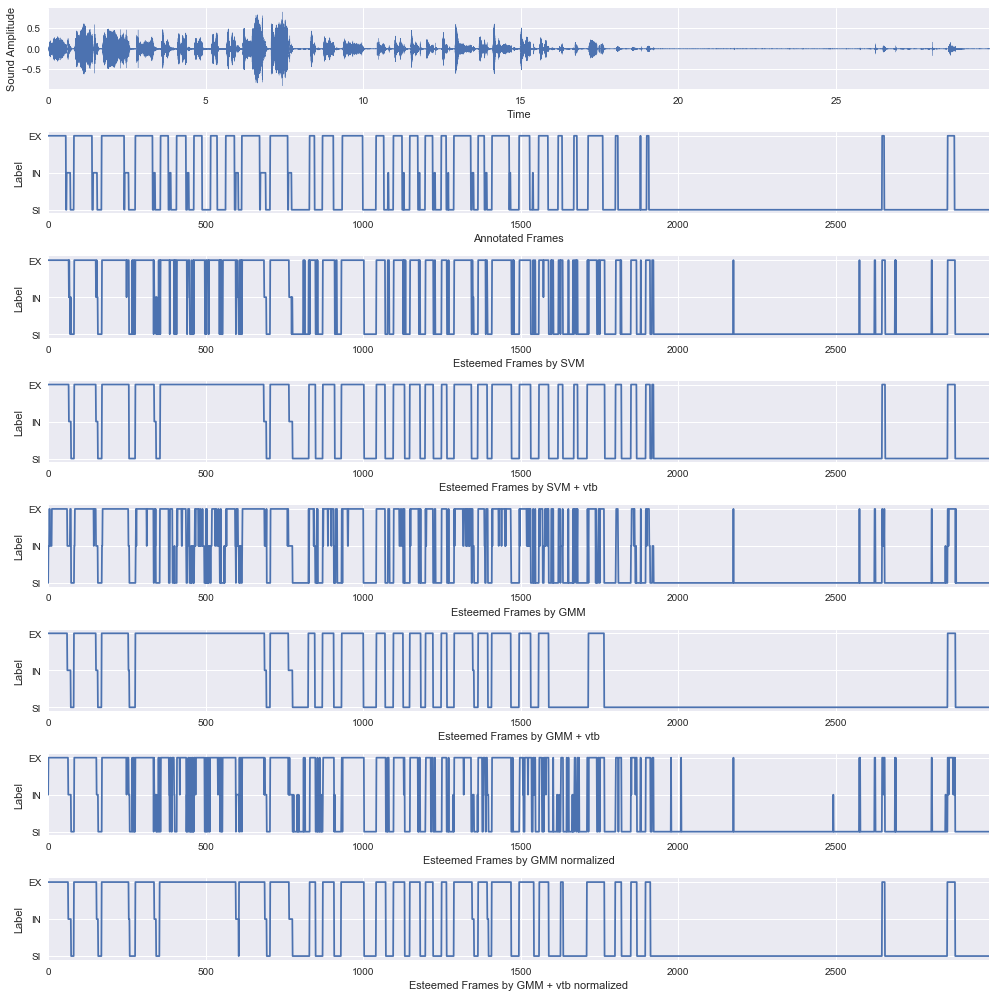

In [24]:
plt.rcParams['figure.figsize'] = (14, 14)

SAMPLING_RATE = 44100
audio_file_path = '044/hungry/audio/00m12d-1(hungry)_044.wav'
audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))

# Plot WaveSound

plt.figure()
plt.subplot(8, 1, 1)
librosa.display.waveplot(audio_data, SAMPLING_RATE)
plt.ylabel('Sound Amplitude')

# Plot excel annotations

plt.subplot(8, 1, 2)
plt.plot(all_file_frame_labels[os.path.basename(audio_file_path)])
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Annotated Frames')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (SVM)

file_mfcc_norm = all_file_mfcc_norm[os.path.basename(audio_file_path)]
predicted_labels = model_svm.predict(file_mfcc_norm)

plt.subplot(8, 1, 3)
plt.plot(predicted_labels)
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by SVM')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (SVM) + viterbi 

log_lhood = log_lhood_svm(file_mfcc_norm,model_svm)
state_seq = log_viterbi(log_lhood, log_trans)

plt.subplot(8, 1, 4)
plt.plot(state_seq)
axes = plt.gca()
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by SVM + vtb')
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (GMM)

file_mfcc = all_file_mfcc[os.path.basename(audio_file_path)]
log_lhood, predicted_labels = predict_gmm3(file_mfcc,model_gmm3)

plt.subplot(8, 1, 5)
plt.plot(predicted_labels)
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by GMM')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (GMM) + viterbi 

state_seq = log_viterbi(log_lhood, log_trans)

plt.subplot(8, 1, 6)
plt.plot(state_seq)
axes = plt.gca()
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by GMM + vtb')
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])
plt.tight_layout()

# Plot classification by frame per frame (GMM) normalized

log_lhood, predicted_labels = predict_gmm3(file_mfcc_norm,model_gmm3_norm)

plt.subplot(8, 1, 7)
plt.plot(predicted_labels)
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by GMM normalized')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (GMM) + viterbi normalized

state_seq = log_viterbi(log_lhood, log_trans)

plt.subplot(8, 1, 8)
plt.plot(state_seq)
axes = plt.gca()
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by GMM + vtb normalized')
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])
plt.tight_layout()

# Extraction of predict states duration and predict start with labels 

In [25]:
state_seq

array([ 2.,  2.,  2., ...,  0.,  0.,  0.])

In [26]:
# To change !

def states_description(state_seq):
    # Init
    start_states = []
    duration_states = []
    type_states = []
    #
    duration_state = 0
    start_state = 0
    frame_before = state_seq[0]
    for i in range(len(state_seq)):
        if (frame_before != state_seq[i]):
            start_states = start_states + [start_state]
            duration_states = duration_states + [duration_state]
            type_states = type_states + [frame_before]
            #
            start_state = start_state + duration_state 
            duration_state = 0
        duration_state = duration_state + 10
        frame_before = state_seq[i]
    # Add the last one
    start_states = start_states + [start_state]
    duration_states = duration_states + [duration_state]
    type_states = type_states + [frame_before]
    # Creation a DataFrame
    df_states = pd.DataFrame({'start' : start_states,\
                         'dur' : duration_states,\
                         'label' : type_states})
    return df_states

def rename_label2(label_str):
    if label_str == 1:
        return 'IN'
    if label_str == 2:
        return 'EX'
    if label_str == 0:
        return 'SI'
    return label_str

In [27]:
df_states = states_description(state_seq)
df_states['label']=df_states['label'].apply(rename_label2)

df_states.head()

,dur,label,start
0,640,EX,0
1,90,IN,640
2,90,SI,730
3,720,EX,820
4,50,IN,1540


# CROSS VALIDATION AND ACCURACY

ten fold cross validation : model_type = 1 for svm and svm+vtb, model_type = 2 for gmm and gmm+vtb

In [28]:
def accuracy_cv(features,labels,model_type,C,gamma,n_components,normalized):
    # Initialization
    kf = KFold(n_splits=10)
    scores_model = np.array([])
    scores_model_vtb = np.array([])
    # Choice of algorithm
    if (model_type == 1):
        algo = 'svm'
    else:
        if (n_components == 5):
            algo = 'gmm5'
        else:
            algo = 'gmm20'
    # Cross_validation
    for train_index, test_index in kf.split(features):
        features_train, features_test = features[train_index], features[test_index]
        labels_train, labels_test = labels[train_index], labels[test_index]
        if (model_type == 1):
            model = sklearn.svm.SVC(C = C, gamma = gamma, probability=True)
            model.fit(features_train, labels_train)
            score_model = model.score(features_test, labels_test)
            log_trans = log_trans_matrix(labels_train)
            score_model_vtb = svm_viterbi_score(features_test,labels_test,log_trans,model)
        else:
            model = train_gmm3(features_train,labels_train,n_components)
            score_model = gmm3_score(features_test,labels_test,model)
            log_trans = log_trans_matrix(labels_train)
            score_model_vtb = gmm3_viterbi_score(features_test,labels_test,log_trans,model)
        scores_model = np.append(scores_model,score_model)
        scores_model_vtb = np.append(scores_model_vtb,score_model_vtb)
    # display scores
    if (normalized == False):
        print('Accuracy ' + algo +  ' with ten fold cross validation :')
    else:
        print('Accuracy ' + algo +  ' normalized with ten fold cross validation :')
    print(scores_model)
    accuracy_model = scores_model.mean()
    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_model, scores_model.std() * 2))
    print('\n')
    if (normalized == False):
        print('Accuracy ' + algo + ' + viterbi with ten fold cross validation :')
    else:
        print('Accuracy ' + algo + ' + viterbi normalized with ten fold cross validation :')
    print(scores_model_vtb)
    accuracy_model_vtb = scores_model_vtb.mean()
    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_model_vtb, scores_model_vtb.std() * 2))
    print('\n')
    return accuracy_model, accuracy_model_vtb

# CROSS VALIDATION FOR DIFFERENTS DATASETS

In [29]:
def creation_data_sets(size_dset,nb_baby):
    baby_states = ['hungry','pee',"sleepy"]
    if (nb_baby == 2):
        babies = ['044','050']
    else:
        babies = ['044','050','051']        
    labels_dsets = {}
    mfcc_dsets = {}
    mfcc_dsets_norm = {}
    for baby in babies:
        for baby_state in baby_states:
            if ((baby!='051')|(baby_state!='pee')):
                concatenate_all_file_mfcc = np.array([]).reshape(0,13)
                concatenate_all_file_mfcc_norm = np.array([]).reshape(0,13)
                concatenate_all_file_frame_labels = []
                audio_files = []
                file_path = baby +'/'+baby_state+'/audio/'
                for audio_file_path in glob.glob(file_path+'*.wav'):
                    audio_file = os.path.basename(audio_file_path)
                    audio_files = audio_files + [audio_file]
                # Shuffle files for keeping time relations for HMM   
                random.shuffle(audio_files)
                for audio_file in audio_files:
                    concatenate_all_file_frame_labels = concatenate_all_file_frame_labels + all_file_frame_labels[audio_file]
                    concatenate_all_file_mfcc = np.append(concatenate_all_file_mfcc,all_file_mfcc[audio_file], axis = 0)
                    concatenate_all_file_mfcc_norm = np.append(concatenate_all_file_mfcc_norm,all_file_mfcc_norm[audio_file], axis = 0)
                # Taking size_dset frames    
                startpoint = int(floor((len(concatenate_all_file_frame_labels)-size_dset)*random.random()))
                labels_dset = copy(concatenate_all_file_frame_labels[startpoint:startpoint+size_dset])
                mfcc_dset = copy(concatenate_all_file_mfcc[startpoint:startpoint+size_dset])
                mfcc_dset_norm = copy(concatenate_all_file_mfcc_norm[startpoint:startpoint+size_dset])
                labels_dsets[baby + '-' + baby_state] = labels_dset
                mfcc_dsets[baby + '-' + baby_state] = mfcc_dset
                mfcc_dsets_norm[baby + '-' + baby_state] = mfcc_dset_norm
    return labels_dsets, mfcc_dsets, mfcc_dsets_norm

You can directly load the results1 file here, if it's already saved

In [34]:
# 6 contexts with different algorithms with 40000 frames : 
#              SVM normalized, GMM5 normalized and not normalized, GMM10 normalized and not normalized
#              SVM+vtb normalized, GMM5+vtb normalized and not normalized, GMM10+vtb normalized and not normalized

results1 = pd.DataFrame.from_csv('results1.csv')

# results1

# Best results in case of algorithm with viterbi and normalization for both GMM and SVM.
# GMM seems to work better with 20 gaussians than with only 5.
# SVM + viterbi seems to be the best algorithm (mean accuracy of 85,83% for 6 datasets with tenfold cross validation)

In [ ]:
C = 1
gamma = 0.1
accuracies1 = {}
babies = ['044','050']
baby_states = ['hungry','pee',"sleepy"]
size_dset = 40000
labels_dsets, mfcc_dsets, mfcc_dsets_norm = creation_data_sets(size_dset,2)

for baby in babies:
    for baby_state in baby_states:
        print(baby + '-' + baby_state)
        print('\n')
        name_dataset = baby + '-' + baby_state
        mfcc_dset = mfcc_dsets[name_dataset]
        mfcc_dset_norm = mfcc_dsets_norm[name_dataset]
        labels_dset = labels_dsets[name_dataset]
        # SVM + SVM/Vtb
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,1,C,gamma,5,True)
        accuracies1[baby + '-' + baby_state + '-' + 'svm norm'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'svm+vtb norm'] = accuracy_model_vtb
        # GMM5 + GMM5/vtb
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset,labels_dset,2,C,gamma,5,False)
        accuracies1[baby + '-' + baby_state + '-' + 'gmm5'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'gmm5+vtb'] = accuracy_model_vtb
        # GMM5 + GMM5/vtb normalized
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,2,C,gamma,5,True)
        accuracies1[baby + '-' + baby_state + '-' + 'gmm5 norm'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'gmm5+vtb norm'] = accuracy_model_vtb
        # GMM20 + GMM20/vtb
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset,labels_dset,2,C,gamma,20,False)
        accuracies1[baby + '-' + baby_state + '-' + 'gmm20'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'gmm20+vtb'] = accuracy_model_vtb
        # GMM20 + GMM20/vtb normalized
        accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,2,C,gamma,20,True)
        accuracies1[baby + '-' + baby_state + '-' + 'gmm20 norm'] = accuracy_model        
        accuracies1[baby + '-' + baby_state + '-' + 'gmm20+vtb norm'] = accuracy_model_vtb

In [ ]:
babies = ['044','050']
baby_states = ['hungry','pee',"sleepy"]
types_algo = ['svm norm','svm+vtb norm','gmm5','gmm5+vtb','gmm5 norm','gmm5+vtb norm','gmm20','gmm20+vtb','gmm20 norm','gmm20+vtb norm']
index = ['44', '44', '44', '50','50', '50']

results1 = pd.DataFrame({'Context' : ['Hung', 'Pee', 'Sleepy', 'Hung','Pee', 'Sleepy'],\
                          'svm norm (%)' : np.random.randn(6),\
                   'svm+vtb norm (%)' : np.random.randn(6),\
                  'gmm5 (%)' : np.random.randn(6),\
                  'gmm5+vtb (%)' : np.random.randn(6),\
                  'gmm5 norm (%)' : np.random.randn(6),\
                  'gmm5+vtb norm (%)' : np.random.randn(6),\
                  'gmm20 (%)' : np.random.randn(6),\
                  'gmm20+vtb (%)' : np.random.randn(6),\
                  'gmm20 norm (%)' : np.random.randn(6),\
                  'gmm20+vtb norm (%)' : np.random.randn(6)}, index = index)

results1 = results1[['Context','svm norm (%)','svm+vtb norm (%)','gmm5 (%)','gmm5+vtb (%)','gmm5 norm (%)','gmm5+vtb norm (%)','gmm20 (%)','gmm20+vtb (%)','gmm20 norm (%)','gmm20+vtb norm (%)']]

i = 0

for baby in babies:
    for baby_state in baby_states:
        for type_algo in types_algo:
            if (type_algo == 'svm norm'):
                results1.iat[i,1] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'svm+vtb norm'):
                results1.iat[i,2] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm5'):
                results1.iat[i,3] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm5+vtb'):
                results1.iat[i,4] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm5 norm'):
                results1.iat[i,5] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm5+vtb norm'):
                results1.iat[i,6] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm20'):
                results1.iat[i,7] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm20+vtb'):
                results1.iat[i,8] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm20 norm'):
                results1.iat[i,9] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
            elif (type_algo == 'gmm20+vtb norm'):
                results1.iat[i,10] = accuracies1[baby + '-' + baby_state + '-' + type_algo]
        i = i + 1        
                
results1.to_csv('results1.csv')

results1

You can directly load the results2 file here, if it's already saved

In [35]:
# 8 contexts with different algorihms with 30000 frames: 
#              SVM normalized, GMM5 normalized , GMM10 normalized
#              SVM+vtb normalized, GMM5+vtb normalized, GMM10+vtb normalized 

results2 = pd.DataFrame.from_csv('results2.csv')

# results2

In [ ]:
C = 1
gamma = 0.1
accuracies2 = {}
size_dset = 30000
labels_dsets, mfcc_dsets, mfcc_dsets_norm = creation_data_sets(size_dset,3)
babies = ['044','050',"051"]
baby_states = ['hungry','pee',"sleepy"]

for baby in babies:
    for baby_state in baby_states:
        print(baby + '-' + baby_state)
        print('\n')
        if ((baby!='051')|(baby_state!='pee')):
            name_dataset = baby + '-' + baby_state
            mfcc_dset = mfcc_dsets[name_dataset]
            mfcc_dset_norm = mfcc_dsets_norm[name_dataset]
            labels_dset = labels_dsets[name_dataset]
            # SVM + SVM/Vtb normalized
            accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,1,C,gamma,5,True)
            accuracies2[baby + '-' + baby_state + '-' + 'svm norm'] = accuracy_model        
            accuracies2[baby + '-' + baby_state + '-' + 'svm+vtb norm'] = accuracy_model_vtb
            # GMM5 + GMM5/vtb normalized
            accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,2,C,gamma,5,True)
            accuracies2[baby + '-' + baby_state + '-' + 'gmm5 norm'] = accuracy_model        
            accuracies2[baby + '-' + baby_state + '-' + 'gmm5+vtb norm'] = accuracy_model_vtb
            # GMM20 + GMM20/vtb normalized
            accuracy_model, accuracy_model_vtb = accuracy_cv(mfcc_dset_norm,labels_dset,2,C,gamma,20,True)
            accuracies2[baby + '-' + baby_state + '-' + 'gmm20 norm'] = accuracy_model        
            accuracies2[baby + '-' + baby_state + '-' + 'gmm20+vtb norm'] = accuracy_model_vtb

In [ ]:
babies = ['044','050','051']
baby_states = ['hungry','pee',"sleepy"]
types_algo = ['svm norm','svm+vtb norm','gmm5 norm','gmm5+vtb norm','gmm20 norm','gmm20+vtb norm']

index = ['44', '44', '44', '50','50', '50','51','51','51']

results2 = pd.DataFrame({'Context' : ['Hung', 'Pee', 'Sleepy', 'Hung','Pee', 'Sleepy','Hung','Pee', 'Sleepy'],\
                          'svm norm (%)' : np.random.randn(9),\
                   'svm+vtb norm (%)' : np.random.randn(9),\
                  'gmm5 norm (%)' : np.random.randn(9),\
                  'gmm5+vtb norm (%)' : np.random.randn(9),\
                  'gmm20 norm (%)' : np.random.randn(9),\
                  'gmm20+vtb norm (%)' : np.random.randn(9)}, index = index)

results2 = results2[['Context','svm norm (%)','svm+vtb norm (%)','gmm5 norm (%)','gmm5+vtb norm (%)','gmm20 norm (%)','gmm20+vtb norm (%)']]

i = 0
            
for baby in babies:
    for baby_state in baby_states:
        if ((baby=='051')&(baby_state=='pee')):
            resultats2.iat[i,1] = NaN
            resultats2.iat[i,2] = NaN
            resultats2.iat[i,3] = NaN
            resultats2.iat[i,4] = NaN
            resultats2.iat[i,5] = NaN
            resultats2.iat[i,6] = NaN
        else:    
            for type_algo in types_algo:
                if (type_algo == 'svm norm'):
                    results2.iat[i,1] = accuracies[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'svm+vtb norm'):
                    results2.iat[i,2] = accuracies[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'gmm5 norm'):
                    results2.iat[i,3] = accuracies[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'gmm5+vtb norm'):
                    results2.iat[i,4] = accuracies[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'gmm20 norm'):
                    results2.iat[i,5] = accuracies[baby + '-' + baby_state + '-' + type_algo]
                elif (type_algo == 'gmm20+vtb norm'):
                    results2.iat[i,6] = accuracies[baby + '-' + baby_state + '-' + type_algo]
        i = i + 1        
                
results2.to_csv('results2.csv')

results2

Color the best CV results

In [32]:
# Color dataframe

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# Transform results dataframe to excel to modify presentation stuffs 

#writer1 = pd.ExcelWriter('pandas_simple1.xlsx', engine='xlsxwriter')
#writer2 = pd.ExcelWriter('pandas_simple2.xlsx', engine='xlsxwriter')
#results1.to_excel(writer1, sheet_name='Sheet1')
#results2.to_excel(writer2, sheet_name='Sheet1')

results1_color = pd.read_excel('pandas_simple1.xlsx','Sheet1')
results2_bis = pd.read_excel('pandas_simple2.xlsx','Sheet1')
results1_color.columns = ['Number','Context','SVM norm','SVM+vtb norm','GMM5','GMM5+vtb','GMM5 norm','GMM5+vtb norm','GMM20','GMM20+vtb','GMM20 norm','GMM20+vtb norm']
results2_color = results2_bis[['Numero','Context','svm+vtb norm (%)','gmm5+vtb norm (%)','gmm20+vtb norm (%)']]
results2_color.columns = ['Number','Context','SVM+vtb norm','GMM5+vtb norm','GMM20+vtb norm']

# Color the best CV results

results1_color = results1_color.style.apply(highlight_max, axis=1,subset=['SVM norm','SVM+vtb norm','GMM5','GMM5+vtb','GMM5 norm','GMM5+vtb norm','GMM20','GMM20+vtb','GMM20 norm','GMM20+vtb norm'])
results2_color = results2_color.style.apply(highlight_max, axis=1,subset=['SVM+vtb norm','GMM5+vtb norm','GMM20+vtb norm'])

# Display data frame

results1_color

In [33]:
results2_color

# Training on the entire Dataset

We train the chosen algorithm (svm+viterbi on the entire datasets). 

In [ ]:
baby_states = ['hungry','pee',"sleepy"]
babies = ['044','050','051']

mfcc_dset_norm = np.array([]).reshape(0,13)
labels_dset = []
audio_files = []

for baby in babies:
    for baby_state in baby_states:
        file_path = baby +'/'+baby_state+'/audio/'
        for audio_file_path in glob.glob(file_path+'*.wav'):
            audio_file = os.path.basename(audio_file_path)
            audio_files = audio_files + [audio_file]
                        
for audio_file in audio_files:
    labels_dset = labels_dset + all_file_frame_labels[audio_file]
    mfcc_dset_norm = np.append(mfcc_dset_norm,all_file_mfcc_norm[audio_file], axis = 0)
    
print(shape(labels_dset),shape(mfcc_dset_norm))

You can directly load the final svm model file here, if it's already saved. It's formed by one SVM model and one log transition matrix. 

In [37]:
final_model = np.load('final_model.npy').item()

model_svm = final_model['model_svm']
log_trans = final_model['log_trans']
final_model

{'log_trans': array([[ -2.30258509e+02,  -1.09861229e+00,  -1.09861229e+00,
          -1.09861229e+00,  -2.30258509e+02],
        [ -2.30258509e+02,  -2.71763788e-02,  -4.79802089e+00,
          -3.98651097e+00,  -2.30258509e+02],
        [ -2.30258509e+02,  -2.63839497e+00,  -7.43373533e-02,
          -8.70566248e+00,  -2.30258509e+02],
        [ -2.30258509e+02,  -3.97479759e+00,  -7.94490806e+00,
          -1.93230591e-02,  -2.30258509e+02],
        [ -2.30258509e+02,  -2.30258509e+02,  -2.30258509e+02,
          -2.30258509e+02,  -2.30258509e+02]]),
 'model_svm': SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
   max_iter=-1, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False)}

Training the svm and the transition Matrix

In [ ]:
# Training
C = 1
gamma = 0.1
model_svm = sklearn.svm.SVC(C = C, gamma = gamma, probability=True)
model_svm.fit(mfcc_dset_norm, labels_dset)
log_trans = log_trans_matrix(labels_dset)

# Saving
final_model = {}
final_model['model_svm'] = model_svm
final_model['log_trans'] = log_trans
np.save('final_model.npy', final_model)

Test the model 

In [36]:
def predict_svm_viterbi(file_mfcc_norm,model_svm,log_trans):
    log_lhood = log_lhood_svm(file_mfcc_norm,model_svm)
    state_seq = log_viterbi(log_lhood, log_trans)
    return state_seq

Comparision between file, annotations et classification with the final model

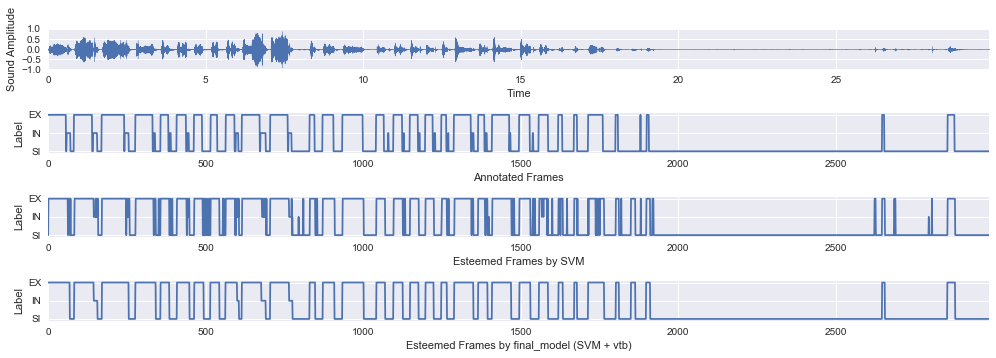

In [38]:
plt.rcParams['figure.figsize'] = (14, 5)

SAMPLING_RATE = 44100
audio_file_path = '044/hungry/audio/00m12d-1(hungry)_044.wav'
audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))

# Plot WaveSound

plt.figure()
plt.subplot(4, 1, 1)
librosa.display.waveplot(audio_data, SAMPLING_RATE)
plt.ylabel('Sound Amplitude')

# Plot excel annotations

plt.subplot(4, 1, 2)
plt.plot(all_file_frame_labels[os.path.basename(audio_file_path)])
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Annotated Frames')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification by frame per frame (svm)

file_mfcc_norm = all_file_mfcc_norm[os.path.basename(audio_file_path)]
predicted_labels = model_svm.predict(file_mfcc_norm)

plt.subplot(4, 1, 3)
plt.plot(predicted_labels)
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by SVM')
axes = plt.gca()
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])

# Plot classification with final model (svm+viterbi) train on all data set.

state_seq = predict_svm_viterbi(file_mfcc_norm,model_svm,log_trans)

plt.subplot(4, 1, 4)
plt.plot(state_seq)
axes = plt.gca()
plt.ylabel('Label')
plt.yticks(arange(3),('SI', 'IN', 'EX'))
plt.xlabel('Esteemed Frames by final_model (SVM + vtb)')
axes.set_xlim([0,len(all_file_frame_labels[os.path.basename(audio_file_path)])])
plt.tight_layout()

In [39]:
# Accuracy on the training dataset of 90.84%

accuracy_final_model = svm_viterbi_score(mfcc_dset_norm,labels_dset,log_trans,model_svm)

accuracy_final_model

0.9084

# Saving all esteemed states in .csv format for babies not annoted 

Firstly, we save esteemed states for not annoted babies 

In [ ]:
SAMPLING_RATE = 44100
L_WINDOWS = 0.020
L_HOPS = 0.010
L_WINDOW_N = int(round((L_WINDOWS)/(1./SAMPLING_RATE)))
L_HOP_N = int(round((L_HOPS)/(1./SAMPLING_RATE)))
L_WINDOW_N2 = 2**(L_WINDOW_N-1).bit_length() # POWER OF 2 FOR FFT
L_HOP_N2 = 2**(L_WINDOW_N-1).bit_length()
N_MFCC = 13

mfcc_scaler = sklearn.preprocessing.StandardScaler()

directory = os.getcwd()
path_files = [x[0] for x in os.walk(directory)]

final_model = np.load('final_model.npy').item()
model_svm = final_model['model_svm']
log_trans = final_model['log_trans']

for path_file in path_files:
    if (path_file.find('audio') != -1):
        file_path_audio = path_file+'/'
        file_path_labels = file_path_audio[:-6]+'labels/'
        for audio_file_path in glob.glob(file_path_audio+'*.wav'):
            print(audio_file_path)
            audio_data = librosa.load(audio_file_path, sr = SAMPLING_RATE)[0]
            audio_data = (audio_data - np.mean(audio_data))/ max(abs(audio_data-np.mean(audio_data)))
            file_mfcc = librosa.feature.mfcc(audio_data, sr=SAMPLING_RATE, \
                                             n_mfcc=N_MFCC, n_fft = L_WINDOW_N, \
                                             hop_length = L_HOP_N).T
            file_mfcc_norm = mfcc_scaler.fit_transform(file_mfcc)
            state_seq = predict_svm_viterbi(file_mfcc_norm,model_svm,log_trans)
            df_states = states_description(state_seq)
            df_states['label']=df_states['label'].apply(rename_label2)
            df_states[['start','dur']] = df_states[['start','dur']].astype(int)
            df_states = df_states[['start','dur','label']]
            df_states.to_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'.csv',sep='\t', index=False)

Secondly, we save states for babies annoted

In [ ]:
labels = pd.DataFrame.from_csv('labels.csv')
labels['label'] = labels['label'].apply(rename_label2)
labels= labels[['start','dur','label','file']]
labels[['start','dur']] = labels[['start','dur']].astype(int)

labels.head()

In [ ]:
start = []
dur = []
label = []
file_name = []

babies = ['044','050','051']
baby_states = ['hungry','pee',"sleepy"]

for baby in babies:
    for baby_state in baby_states:
        file_path_audio = baby +'/'+baby_state+'/audio/'
        file_path_labels = baby +'/'+baby_state+'/labels/'
        for audio_file_path in glob.glob(file_path_audio+'*.wav'):
            labels_file = labels[labels.file == os.path.basename(audio_file_path)]
            lenght_label_file = len(labels_file.index)
            for i in range(lenght_label_file-1):
                start = start + [labels_file.iloc[i]['start']]
                dur = dur + [labels_file.iloc[i]['dur']]
                label = label + [labels_file.iloc[i]['label']]
                file_name = file_name + [os.path.basename(audio_file_path)]
                if ((labels_file.iloc[i]['start']+labels_file.iloc[i]['dur'])<labels_file.iloc[i+1]['start']):
                    start_time = labels_file.iloc[i]['start']+labels_file.iloc[i]['dur']
                    start = start + [start_time]
                    dur = dur + [labels_file.iloc[i+1]['start']-start_time]
                    label = label + ['SI']
                    file_name = file_name + [os.path.basename(audio_file_path)]
            start = start + [labels_file.iloc[lenght_label_file-1]['start']]
            dur = dur + [labels_file.iloc[lenght_label_file-1]['dur']]
            label = label + [labels_file.iloc[lenght_label_file-1]['label']]
            file_name = file_name + [os.path.basename(audio_file_path)]

label_Annotated = pd.DataFrame({'start' : start,\
                                'dur' : dur,\
                                'label' : label,\
                                'file' : file_name})

label_Annotated= label_Annotated[['start','dur','label','file']]
label_Annotated[['start','dur']] = label_Annotated[['start','dur']].astype(int)
label_Annotated.head()

In [ ]:
babies = ['044','050','051']
baby_states = ['hungry','pee',"sleepy"]

for baby in babies:
    for baby_state in baby_states:  
        file_path_audio = baby +'/'+baby_state+'/audio/'
        file_path_labels = baby +'/'+baby_state+'/labels/'
        for audio_file_path in glob.glob(file_path_audio+'*.wav'):
            labels_file = label_Annotated[label_Annotated.file == os.path.basename(audio_file_path)]
            labels_file = labels_file[['start','dur','label']]
            labels_file.to_csv(file_path_labels+os.path.splitext(os.path.basename(audio_file_path))[0]+'.csv',sep='\t', index=False)